# Otimização dos Grupos Homogênios (GHs)

## 0 - Importação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import OptimalBinning
import seaborn as sns
from pingouin import pairwise_ttests

from sklearn.metrics import roc_curve, auc
from scipy.stats import ks_2samp

%matplotlib inline
pd.set_option('display.max_rows', 100)

import warnings

# Ignorar especificamente RuntimeWarning
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',200)

## 1 - Leitura dos Dados

In [2]:
df_pred = pd.read_csv('dados/df_final_gh_calibrado.csv')
df_pred

,id,y,safra,predict_proba,bin,predict_proba_calib
0,1,0,201404,0.100468,1,0.047782
1,2,0,201407,0.133744,1,0.097054
2,3,0,201405,0.327221,3,0.357771
3,5,1,201403,0.604421,4,0.800000
4,6,0,201405,0.330365,3,0.357771
...,...,...,...,...,...,...
10733,10703,0,201411,0.156619,1,0.133028
10734,10706,0,201412,0.212954,2,0.192888
10735,10713,1,201411,0.555761,4,0.656965
10736,10727,0,201412,0.204414,2,0.192888


In [3]:
target='y'
df_train_pred = df_pred[df_pred['safra']<=201408]
df_train_pred[target] = df_train_pred[target].astype(int)

## 2 - Definindo Percentis

In [4]:
df_train_pred['predict_proba_calib'].describe()

count    7334.000000
mean        0.295694
std         0.177912
min         0.000000
25%         0.142395
50%         0.284024
75%         0.435294
max         1.000000
Name: predict_proba_calib, dtype: float64

In [6]:
quandidade_percentis =10
u=quandidade_percentis

In [7]:
optb = OptimalBinning(
        name='predict_proba_calib',
        min_event_rate_diff=0.001,
        dtype="numerical",
        solver="cp",
        min_n_bins=quandidade_percentis,
        max_pvalue=0.05,
        max_n_bins=quandidade_percentis, # default 20
        min_prebin_size=0.05, #0.01,
        special_codes=[-1],
        monotonic_trend="auto_asc_desc")
    
optb.fit(df_train_pred['predict_proba_calib'].values, df_train_pred[target].values)

OptimalBinning(max_n_bins=10, max_pvalue=0.05, min_event_rate_diff=0.001,
               min_n_bins=10, monotonic_trend='auto_asc_desc',
               name='predict_proba_calib', special_codes=[-1])

In [8]:
# df_train_pred['score_quantile_20'] = pd.qcut(df_train_pred['predict_proba_calib'], q=u, labels=range(1,(u+1)), precision = 0)
df_train_pred['score_quantile_20'] = optb.transform(df_train_pred['predict_proba_calib'].values, metric="indices")+1


df_train = pd.DataFrame(df_train_pred.groupby(['score_quantile_20'],as_index=False).apply(lambda x: x[target].sum()/len(x)))
df_train.columns = ['score_quantile_20', 'Bad_Rate']

### Visualização Bad Rate - Percentis

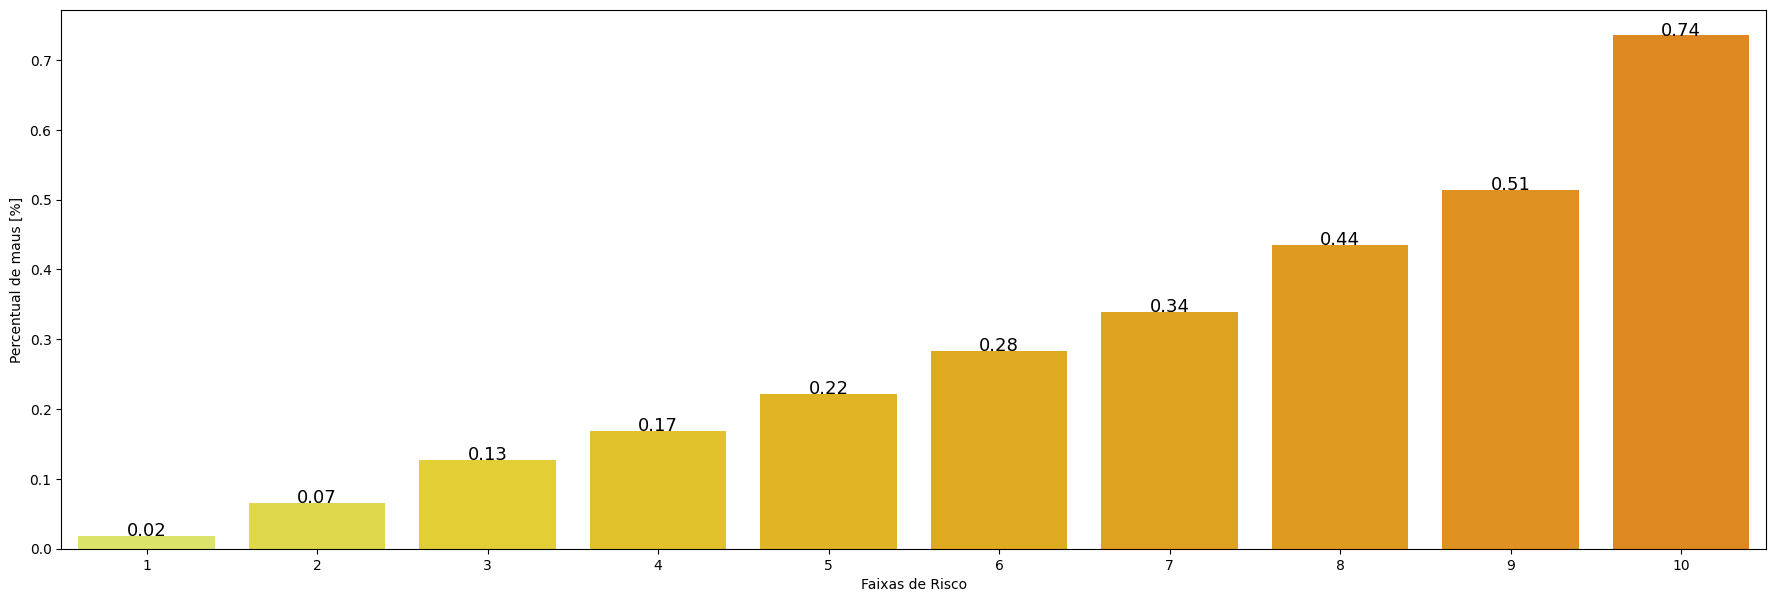

In [9]:
plt.rcParams["figure.figsize"] = (22, 7)
g =sns.barplot(x='score_quantile_20',y='Bad_Rate',data=df_train, palette = "Wistia")
g.set(xlabel = 'Faixas de Risco', ylabel = 'Percentual de maus [%]')
for index, row in df_train.iterrows():
    g.text(row.name,row.Bad_Rate, round(row.Bad_Rate,2), color='black', ha="center", size=13)

### Amostra para agrupar os GHs semelhantes

In [10]:
AUX=quandidade_percentis+1
for x in range(1,AUX):
    import numpy as np
    import scipy.stats as st
    fatia = df_train_pred[df_train_pred['score_quantile_20']==x]
    N     = len(fatia.index)                  #Tamanho População
    prop  = np.sum(fatia[target])/N
    alpha = 0.05 #margem de erro
    n_sided = 2 # 2-sided test
    z_score = st.norm.ppf(1-alpha/n_sided) #z-score
    n= round(((z_score)*(prop)*(1-prop))/(alpha*alpha),0)
    print('A amostra ideal no quantile ' + str(x) + ' é igual a: ' +  str(n))

A amostra ideal no quantile 1 é igual a: 14.0
A amostra ideal no quantile 2 é igual a: 48.0
A amostra ideal no quantile 3 é igual a: 87.0
A amostra ideal no quantile 4 é igual a: 110.0
A amostra ideal no quantile 5 é igual a: 136.0
A amostra ideal no quantile 6 é igual a: 159.0
A amostra ideal no quantile 7 é igual a: 176.0
A amostra ideal no quantile 8 é igual a: 193.0
A amostra ideal no quantile 9 é igual a: 196.0
A amostra ideal no quantile 10 é igual a: 153.0


In [11]:
df_sample = df_train_pred.sample(frac=1) # como temos poucos dados, usaremos todo o dataset

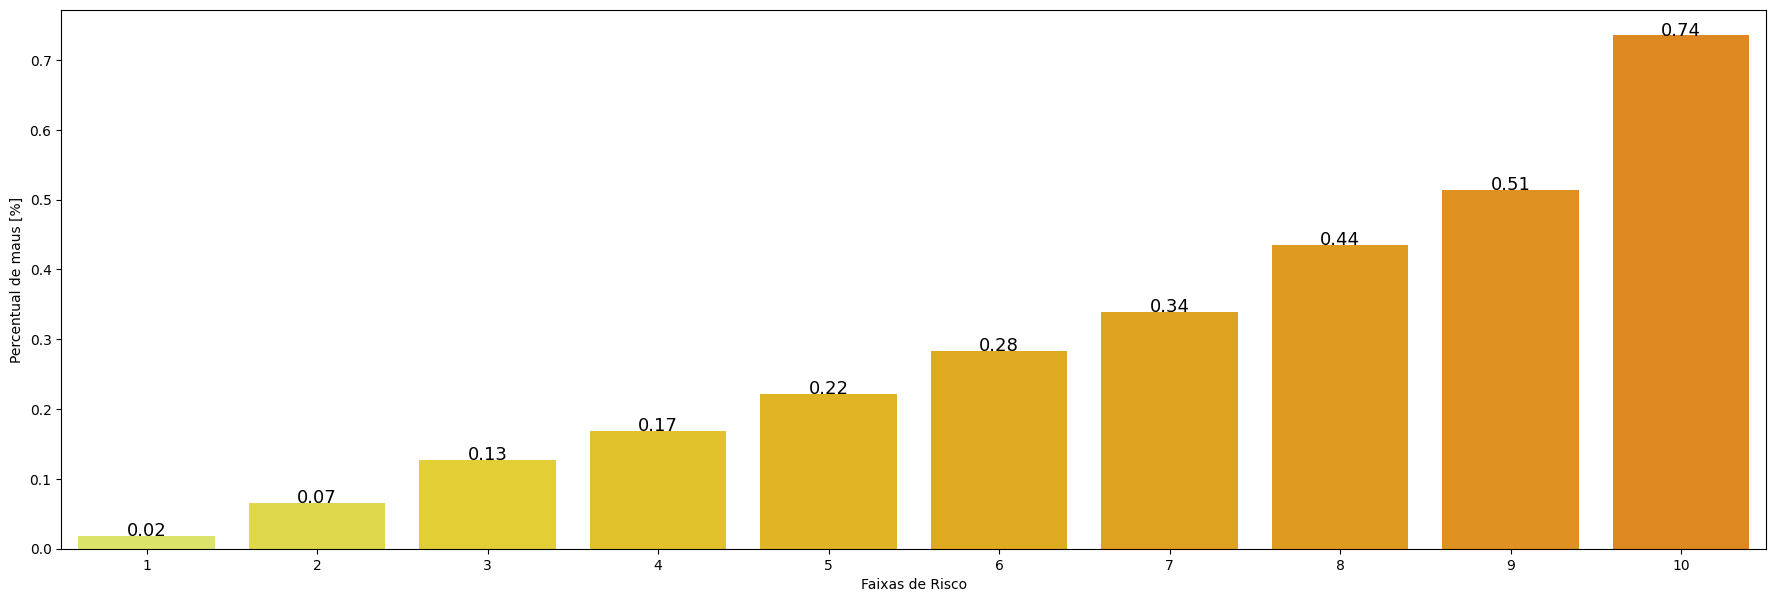

In [12]:
df_sample_2 = pd.DataFrame(df_sample.groupby(['score_quantile_20'],as_index=False).apply(lambda x: x[target].sum()/len(x)))
df_sample_2.columns = ['score_quantile_20', 'Bad_Rate']

plt.rcParams["figure.figsize"] = (22, 7)
g =sns.barplot(x='score_quantile_20',y='Bad_Rate',data=df_sample_2, palette = "Wistia")
g.set(xlabel = 'Faixas de Risco', ylabel = 'Percentual de maus [%]')
for index, row in df_sample_2.iterrows():
    g.text(row.name,row.Bad_Rate, round(row.Bad_Rate,2), color='black', ha="center", size=13)

In [13]:
df_sample['score_quantile_20'].value_counts(0).sort_index()

score_quantile_20
1      493
2      613
3      908
4      634
5      585
6     1837
7      454
8      774
9      549
10     487
Name: count, dtype: int64

## 3 - Agrupando GHs Testes de Hipótese - BonFerroni

In [14]:
%%time
posthocs = pairwise_ttests(dv=target,parametric=False, between='score_quantile_20', padjust='bonf', data=df_sample, correction=True).round(8)
posthocs

CPU times: user 104 ms, sys: 29.6 ms, total: 134 ms
Wall time: 136 ms


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,score_quantile_20,1,2,False,False,144003.0,two-sided,1.609900e-04,7.244540e-03,bonf,-0.229520
1,score_quantile_20,1,3,False,False,199314.0,two-sided,0.000000e+00,0.000000e+00,bonf,-0.390259
2,score_quantile_20,1,4,False,False,132758.5,two-sided,0.000000e+00,0.000000e+00,bonf,-0.510205
3,score_quantile_20,1,5,False,False,114790.0,two-sided,0.000000e+00,0.000000e+00,bonf,-0.637633
4,score_quantile_20,1,6,False,False,332907.0,two-sided,0.000000e+00,0.000000e+00,bonf,-0.653833
5,score_quantile_20,1,7,False,False,75993.0,two-sided,0.000000e+00,0.000000e+00,bonf,-0.937426
6,score_quantile_20,1,8,False,False,111203.5,two-sided,0.000000e+00,0.000000e+00,bonf,-1.050831
7,score_quantile_20,1,9,False,False,68286.0,two-sided,0.000000e+00,0.000000e+00,bonf,-1.321334
8,score_quantile_20,1,10,False,False,33990.0,two-sided,0.000000e+00,0.000000e+00,bonf,-2.200150
9,score_quantile_20,2,3,False,False,260908.0,two-sided,8.166000e-05,3.674890e-03,bonf,-0.206829


In [15]:
posthocs['C']=posthocs['B']-posthocs['A']
posthocs_filtered = posthocs[posthocs['p-corr']>0.05]
posthocs_filtered.head()

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges,C
17,score_quantile_20,3,4,False,False,276030.0,two-sided,0.024294,1.000000,bonf,-0.116678,1
24,score_quantile_20,4,5,False,False,175532.5,two-sided,0.018530,0.833868,bonf,-0.135179,1
30,score_quantile_20,5,6,False,False,504627.5,two-sided,0.003829,0.172322,bonf,-0.137458,1
35,score_quantile_20,6,7,False,False,393590.0,two-sided,0.018777,0.844975,bonf,-0.123248,1
42,score_quantile_20,8,9,False,False,195835.5,two-sided,0.004958,0.223094,bonf,-0.157108,1


In [16]:
# Função para unir clusters garantindo que todos os pares dentro do grupo tenham correlação
def unir_clusters_completos(posthocs_filtered, total_bins):
    # Criar uma matriz de adjacência para verificar as correlações entre todos os pares
    matriz_adjacencia = np.zeros((total_bins + 1, total_bins + 1), dtype=bool)
    
    for _, row in posthocs_filtered.iterrows():
        a, b = int(row['A']), int(row['B'])
        matriz_adjacencia[a, b] = True
        matriz_adjacencia[b, a] = True  # Adicionar bidirecionalidade

    # Função para verificar se todos os pares dentro de um grupo estão correlacionados
    def todos_pares_correlacionados(grupo):
        for i in range(len(grupo)):
            for j in range(i + 1, len(grupo)):
                if not matriz_adjacencia[grupo[i], grupo[j]]:
                    return False
        return True

    # Agrupar os bins com base nas correlações completas entre os pares
    clusters = []
    agrupados = set()

    for i in range(1, total_bins + 1):
        if i not in agrupados:
            grupo_atual = [i]
            for j in range(i + 1, total_bins + 1):
                if todos_pares_correlacionados(grupo_atual + [j]):
                    grupo_atual.append(j)
                else:
                    break
            clusters.append(grupo_atual)
            agrupados.update(grupo_atual)

    return clusters

# Definir o número total de bins (10 neste exemplo)
total_bins = quandidade_percentis

# Obter os clusters com base nas correlações completas entre os pares
clusters = unir_clusters_completos(posthocs_filtered, total_bins)
clusters

[[1], [2], [3, 4], [5, 6], [7], [8, 9], [10]]

In [17]:
# Criar uma coluna que atribui os grupos aos bins de acordo com as regras
def atribuir_grupos_completos(row, clusters):
    ind=1
    for cluster in clusters:
        if row['score_quantile_20'] in cluster:
            return f"b{ind:02d}_{min(cluster):02d}-{max(cluster):02d}"
        ind+=1
    return None

df_sample['score_quantile_20_bon'] = df_sample.apply(atribuir_grupos_completos, clusters=clusters, axis=1)

# # Exibir os clusters e o dataframe atualizado
print(clusters)
print(df_sample[['score_quantile_20', 'score_quantile_20_bon']])

[[1], [2], [3, 4], [5, 6], [7], [8, 9], [10]]
      score_quantile_20 score_quantile_20_bon
6452                  3             b03_03-04
3435                  3             b03_03-04
6852                  9             b06_08-09
4371                  3             b03_03-04
6133                  6             b04_05-06
...                 ...                   ...
6299                  6             b04_05-06
2504                 10             b07_10-10
735                   8             b06_08-09
286                   7             b05_07-07
4882                  6             b04_05-06

[7334 rows x 2 columns]


In [18]:
df_sample[df_sample['score_quantile_20'].isnull()]

,id,y,safra,predict_proba,bin,predict_proba_calib,score_quantile_20,score_quantile_20_bon


### Aplicando os GHs

In [19]:
df_sample = df_train_pred.sample(frac=1)

In [20]:
df_sample['score_quantile_20_bon'] = df_sample.apply(atribuir_grupos_completos, clusters=clusters, axis=1)

In [21]:
%%time
posthocs2 = pairwise_ttests(dv=target, parametric=True, between='score_quantile_20_bon', padjust='bonf', data=df_sample, correction=True).round(6)
posthocs2

CPU times: user 56.4 ms, sys: 3.21 ms, total: 59.6 ms
Wall time: 61.1 ms


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,score_quantile_20_bon,b01_01-01,b02_02-02,False,True,-4.028615,978.524236,two-sided,0.000060,0.001270,bonf,193.004,-0.229520
1,score_quantile_20_bon,b01_01-01,b03_03-04,False,True,-11.697054,1979.910731,two-sided,0.000000,0.000000,bonf,1.977e+27,-0.403143
2,score_quantile_20_bon,b01_01-01,b04_05-06,False,True,-23.071198,2551.414268,two-sided,0.000000,0.000000,bonf,2.417e+104,-0.613202
3,score_quantile_20_bon,b01_01-01,b05_07-07,False,True,-13.925090,519.562337,two-sided,0.000000,0.000000,bonf,6.109e+36,-0.937426
4,score_quantile_20_bon,b01_01-01,b06_08-09,False,True,-29.991078,1710.884913,two-sided,0.000000,0.000000,bonf,5.092e+156,-1.040843
5,score_quantile_20_bon,b01_01-01,b07_10-10,False,True,-34.288414,573.705252,two-sided,0.000000,0.000000,bonf,4.536e+165,-2.200150
6,score_quantile_20_bon,b02_02-02,b03_03-04,False,True,-5.916476,1586.215480,two-sided,0.000000,0.000000,bonf,1.621e+06,-0.243723
7,score_quantile_20_bon,b02_02-02,b04_05-06,False,True,-15.107532,1724.604289,two-sided,0.000000,0.000000,bonf,1.671e+46,-0.493794
8,score_quantile_20_bon,b02_02-02,b05_07-07,False,True,-11.236055,634.804858,two-sided,0.000000,0.000000,bonf,3.047e+24,-0.757359
9,score_quantile_20_bon,b02_02-02,b06_08-09,False,True,-23.725140,1926.184175,two-sided,0.000000,0.000000,bonf,3.249e+105,-0.924185


In [22]:
posthocs2[posthocs2['p-corr']>0.05]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
15,score_quantile_20_bon,b04_05-06,b05_07-07,False,True,-2.951651,610.602096,two-sided,0.003282,0.068924,bonf,4.264,-0.158002


In [23]:
font = {'family' : 'DeJavu Serif',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

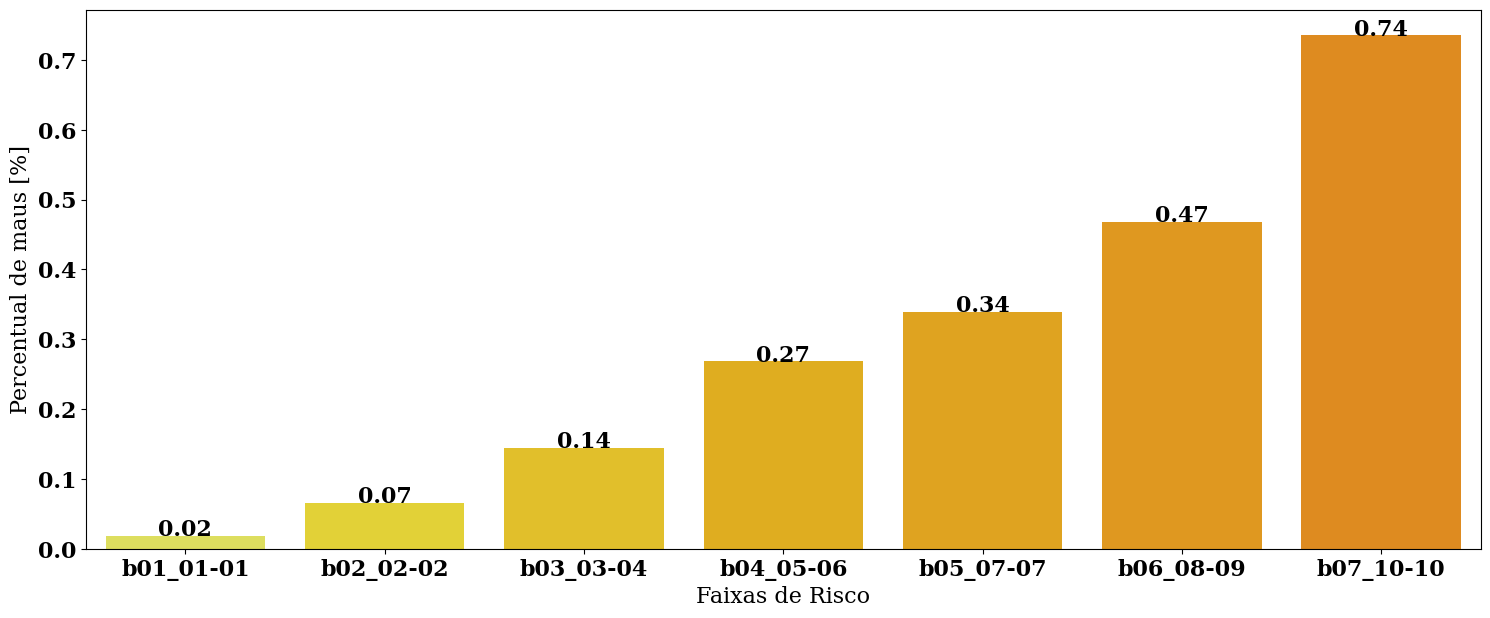

In [24]:
df_sample2 = pd.DataFrame(df_sample.groupby(['score_quantile_20_bon'],as_index=False).apply(lambda x: x[target].sum()/len(x)))
df_sample2.columns = ['score_quantile_20_bon', 'Bad_Rate']

plt.rcParams["figure.figsize"] = (18, 7)
f =sns.barplot(x='score_quantile_20_bon',y='Bad_Rate',data=df_sample2, palette = "Wistia")
f.set(xlabel = 'Faixas de Risco', ylabel = 'Percentual de maus [%]')
for index, row in df_sample2.iterrows():
    f.text(row.name,row.Bad_Rate, round(row.Bad_Rate,2), color='black', ha="center")

## 4 - Aplicando GHs na Validação

In [25]:
df_val_pred = df_pred[df_pred['safra'].isin([201409,201410])]
df_val_pred.head()

,id,y,safra,predict_proba,bin,predict_proba_calib
7334,8,0,201409,0.326163,3,0.357771
7335,41,0,201410,0.121234,1,0.097054
7336,55,1,201409,0.539464,4,0.656965
7337,56,0,201410,0.161708,1,0.142395
7338,58,0,201410,0.158042,1,0.142395


In [26]:
u=quandidade_percentis

# df_val_pred['score_quantile_20'] = pd.qcut(df_val_pred['predict_proba_calib'], q=u, labels=range(1,(u+1)), precision = 0)
df_val_pred['score_quantile_20'] = optb.transform(df_val_pred['predict_proba_calib'].values, metric="indices")+1

In [27]:
df_val_pred['score_quantile_20_bon'] = df_val_pred.apply(atribuir_grupos_completos, clusters=clusters, axis=1)

In [28]:
df_sample_3 = df_val_pred.sample(frac=1)

posthocs4 = pairwise_ttests(dv=target,parametric=True, between='score_quantile_20_bon', padjust='bonf', data=df_sample_3, correction=True).round(8)
pd.set_option('display.max_rows', 15) 
posthocs4

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,score_quantile_20_bon,b01_01-01,b02_02-02,False,True,-2.708485,211.458853,two-sided,7.312630e-03,1.535652e-01,bonf,3.988,-0.315331
1,score_quantile_20_bon,b01_01-01,b03_03-04,False,True,-5.664703,572.242958,two-sided,2.000000e-08,4.900000e-07,bonf,4.151e+05,-0.389846
2,score_quantile_20_bon,b01_01-01,b04_05-06,False,True,-12.417340,729.940126,two-sided,0.000000e+00,0.000000e+00,bonf,7.814e+28,-0.686230
3,score_quantile_20_bon,b01_01-01,b05_07-07,False,True,-8.526295,103.884051,two-sided,0.000000e+00,0.000000e+00,bonf,4.933e+12,-1.397572
4,score_quantile_20_bon,b01_01-01,b06_08-09,False,True,-16.466132,400.833681,two-sided,0.000000e+00,0.000000e+00,bonf,1.895e+45,-1.216335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,score_quantile_20_bon,b04_05-06,b06_08-09,False,True,-6.411426,608.051097,two-sided,0.000000e+00,1.000000e-08,bonf,3.042e+07,-0.463126
17,score_quantile_20_bon,b04_05-06,b07_10-10,False,True,-7.814976,173.192895,two-sided,0.000000e+00,0.000000e+00,bonf,2.642e+11,-0.798169
18,score_quantile_20_bon,b05_07-07,b06_08-09,False,True,-0.887717,156.978972,two-sided,3.760512e-01,1.000000e+00,bonf,0.187,-0.103442
19,score_quantile_20_bon,b05_07-07,b07_10-10,False,True,-3.002989,198.076320,two-sided,3.018030e-03,6.337864e-02,bonf,9.732,-0.411864


In [29]:
posthocs4[posthocs4['p-corr']>0.05]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,score_quantile_20_bon,b01_01-01,b02_02-02,False,True,-2.708485,211.458853,two-sided,0.007313,0.153565,bonf,3.988,-0.315331
6,score_quantile_20_bon,b02_02-02,b03_03-04,False,True,-1.543843,316.308922,two-sided,0.123626,1.000000,bonf,0.336,-0.136921
15,score_quantile_20_bon,b04_05-06,b05_07-07,False,True,-3.066202,124.223021,two-sided,0.002661,0.055876,bonf,10.807,-0.360532
18,score_quantile_20_bon,b05_07-07,b06_08-09,False,True,-0.887717,156.978972,two-sided,0.376051,1.000000,bonf,0.187,-0.103442
19,score_quantile_20_bon,b05_07-07,b07_10-10,False,True,-3.002989,198.076320,two-sided,0.003018,0.063379,bonf,9.732,-0.411864
20,score_quantile_20_bon,b06_08-09,b07_10-10,False,True,-2.896326,229.442774,two-sided,0.004141,0.086952,bonf,6.464,-0.301406


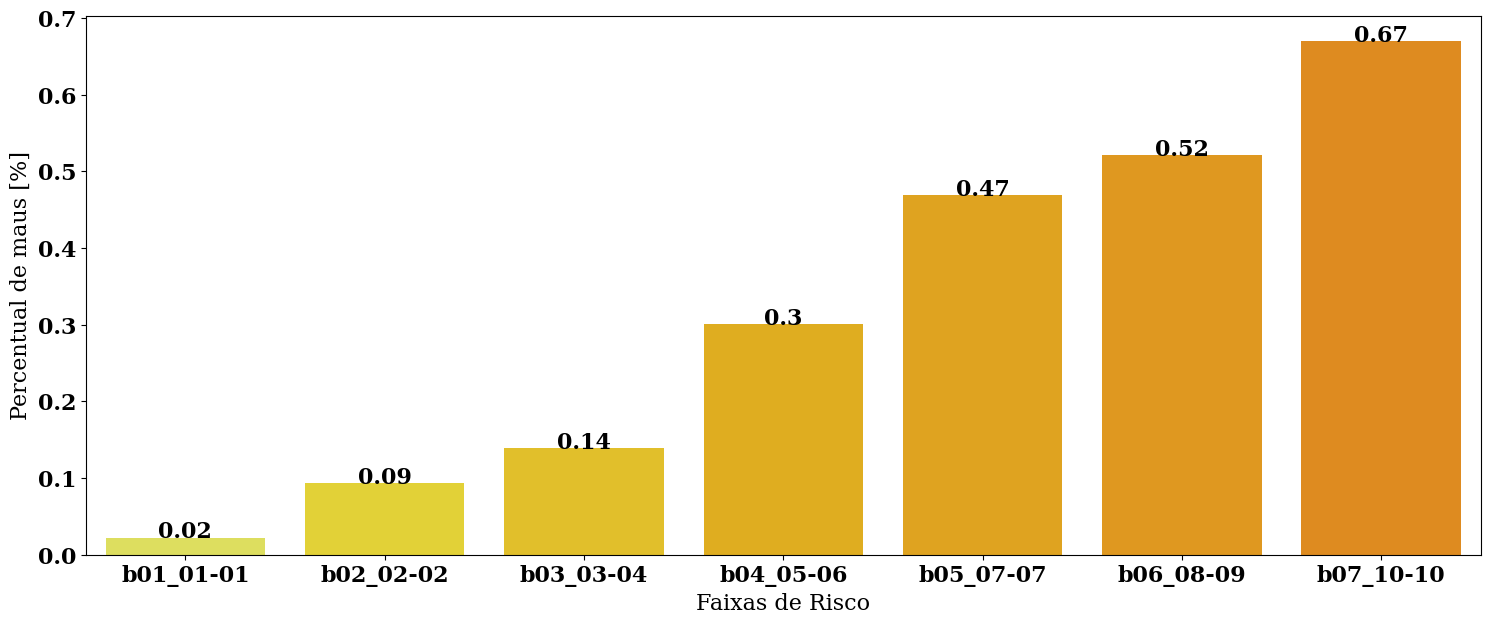

In [30]:
df_valid = pd.DataFrame(df_val_pred.groupby(['score_quantile_20_bon'],as_index=False).apply(lambda x: x[target].sum()/len(x)))

df_valid.columns = ['score_quantile_20_bon', 'Bad_Rate']
plt.rcParams["figure.figsize"] = (18, 7)
g =sns.barplot(x='score_quantile_20_bon',y='Bad_Rate',data=df_valid, palette = "Wistia")
g.set(xlabel = 'Faixas de Risco', ylabel = 'Percentual de maus [%]')
for index, row in df_valid.iterrows():
    g.text(row.name,row.Bad_Rate, round(row.Bad_Rate,2), color='black', ha="center")

## 5 - Avaliando Estabilidade

In [31]:
df_full_train_valid = df_train_pred#pd.concat([df_train_pred, df_val_pred])

optb = OptimalBinning(
        name='predict_proba_calib',
        min_event_rate_diff=0.001,
        dtype="numerical",
        solver="cp",
        min_n_bins=2,
        max_pvalue=0.05,
        max_n_bins=quandidade_percentis, # default 20
        min_prebin_size=0.05, #0.01,
        special_codes=[-1],
        monotonic_trend="auto_asc_desc")
    
optb.fit(df_full_train_valid['predict_proba_calib'].values, df_full_train_valid[target].values)

# df_full_train_valid['score_quantile_20'] = pd.qcut(df_full_train_valid['predict_proba_calib'], q=u, labels=range(1,(u+1)), precision = 0)
df_full_train_valid['score_quantile_20'] = optb.transform(df_full_train_valid['predict_proba_calib'].values, metric="indices")+1

posthocs = pairwise_ttests(dv=target,parametric=False, between='score_quantile_20', padjust='bonf', data=df_full_train_valid, correction=True).round(8)
posthocs['C']=posthocs['B']-posthocs['A']
posthocs_filtered = posthocs[posthocs['p-corr']>0.05]

total_bins = quandidade_percentis

# Obter os clusters com base nas correlações completas entre os pares
clusters = unir_clusters_completos(posthocs_filtered, total_bins)


df_full_train_valid['score_quantile_20_bon'] = df_full_train_valid.apply(atribuir_grupos_completos, clusters=clusters, axis=1)

# # Exibir os clusters e o dataframe atualizado
print(clusters)
df_full_train_valid[['score_quantile_20', 'score_quantile_20_bon']]



[[1], [2], [3, 4], [5], [6], [7, 8], [9], [10]]


,score_quantile_20,score_quantile_20_bon
0,1,b01_01-01
1,2,b02_02-02
2,6,b05_06-06
3,9,b07_09-09
4,6,b05_06-06
...,...,...
7329,6,b05_06-06
7330,6,b05_06-06
7331,9,b07_09-09
7332,5,b04_05-05


In [32]:
df_full = df_pred

# df_full['score_quantile_20'] = pd.qcut(df_full['predict_proba'], q=5, labels=range(1, 6), precision = 0)
df_full['score_quantile_20'] = optb.transform(df_full['predict_proba_calib'].values, metric="indices")+1
df_full.head()

,id,y,safra,predict_proba,bin,predict_proba_calib,score_quantile_20
0,1,0,201404,0.100468,1,0.047782,1
1,2,0,201407,0.133744,1,0.097054,2
2,3,0,201405,0.327221,3,0.357771,6
3,5,1,201403,0.604421,4,0.800000,9
4,6,0,201405,0.330365,3,0.357771,6


In [33]:
df_full['score_quantile_20_bon'] = df_full.apply(atribuir_grupos_completos, clusters=clusters, axis=1)

In [34]:
list_bins = list(sorted(set(df_full['score_quantile_20_bon'].values)))

for v_bin in list_bins:
    df_tmp = df_full[df_full['score_quantile_20_bon']==v_bin]
    print(v_bin)
    print(f"MIN:{np.round(df_tmp['predict_proba_calib'].min(),4)} - MAX:{np.round(df_tmp['predict_proba_calib'].max(),4)}")
    print("===================================================")

b01_01-01
MIN:0.0 - MAX:0.0478
b02_02-02
MIN:0.08 - MAX:0.0971
b03_03-04
MIN:0.1 - MAX:0.1929
b04_05-05
MIN:0.2353 - MAX:0.2863
b05_06-06
MIN:0.2973 - MAX:0.4353
b06_07-08
MIN:0.4353 - MAX:0.5667
b07_09-09
MIN:0.6 - MAX:1.0


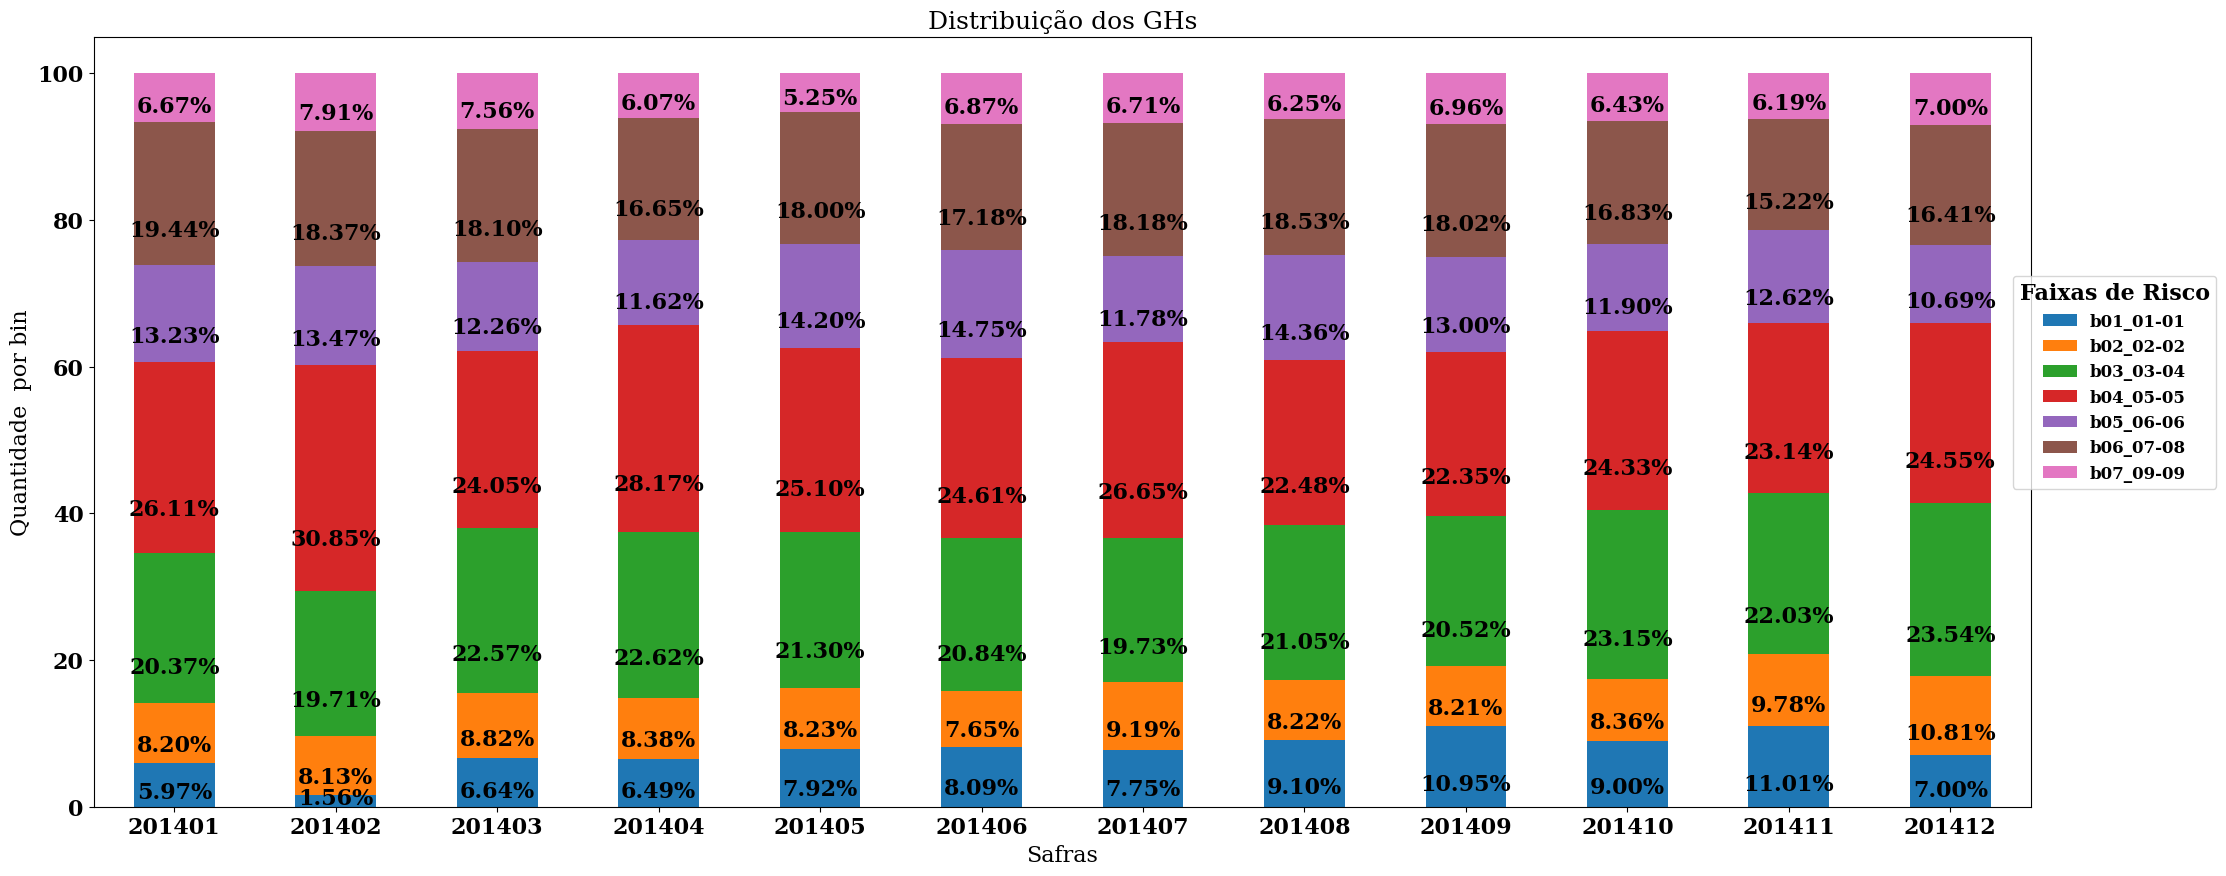

In [35]:
def graph_distribution_bins(df, title):
    GROUP_QTD = df.groupby(['safra','score_quantile_20_bon']).size().unstack().sort_values(by='safra',ascending=True)
    
    ax = (GROUP_QTD.T*100.0/GROUP_QTD.T.sum()).T.plot(kind='bar',figsize=(25,10),width=0.5,stacked=True, rot=0)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x ,y = p.get_xy()
        ax.annotate('{:.2f}%'.format(height), (x + width/2, y + height*0.2), ha='center')
    
    ax.set_xlabel('Safras', fontsize=16)
    ax.set_ylabel('Quantidade  por bin', fontsize=16)
    plt.legend(title='Faixas de Risco', loc='upper right', bbox_to_anchor=(1.1, 0.7), fontsize=12)
    plt.title(title, fontsize=18)
    plt.show()
    
graph_distribution_bins(df_full, f"Distribuição dos GHs")

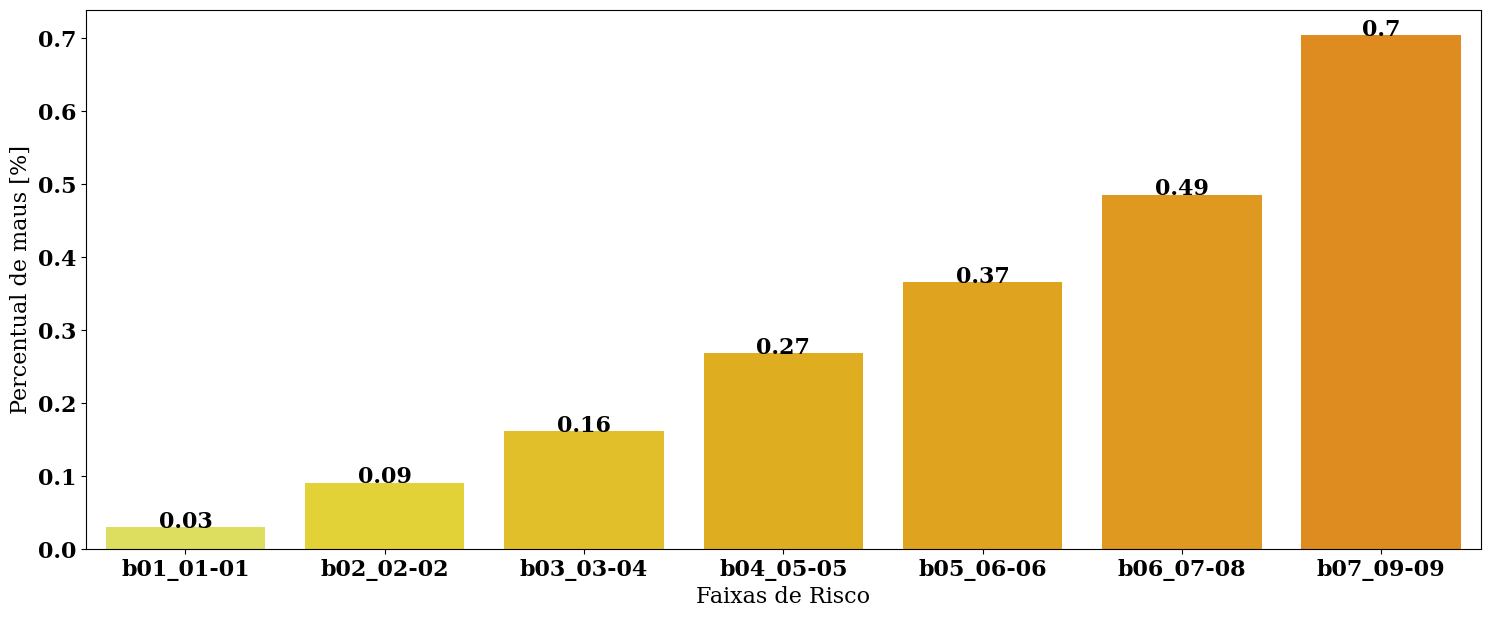

In [36]:
df_full_2 = pd.DataFrame(df_full.groupby(['score_quantile_20_bon'],as_index=False).apply(lambda x: x[target].sum()/len(x)))
df_full_2.columns = ['score_quantile_20_bon', 'Bad_Rate']

plt.rcParams["figure.figsize"] = (18, 7)
g =sns.barplot(x='score_quantile_20_bon',y='Bad_Rate',data=df_full_2, palette = "Wistia")
g.set(xlabel = 'Faixas de Risco', ylabel = 'Percentual de maus [%]')
for index, row in df_full_2.iterrows():
    g.text(row.name,row.Bad_Rate, round(row.Bad_Rate,2), color='black', ha="center")

In [37]:
font = {'family' : 'DeJavu Serif',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

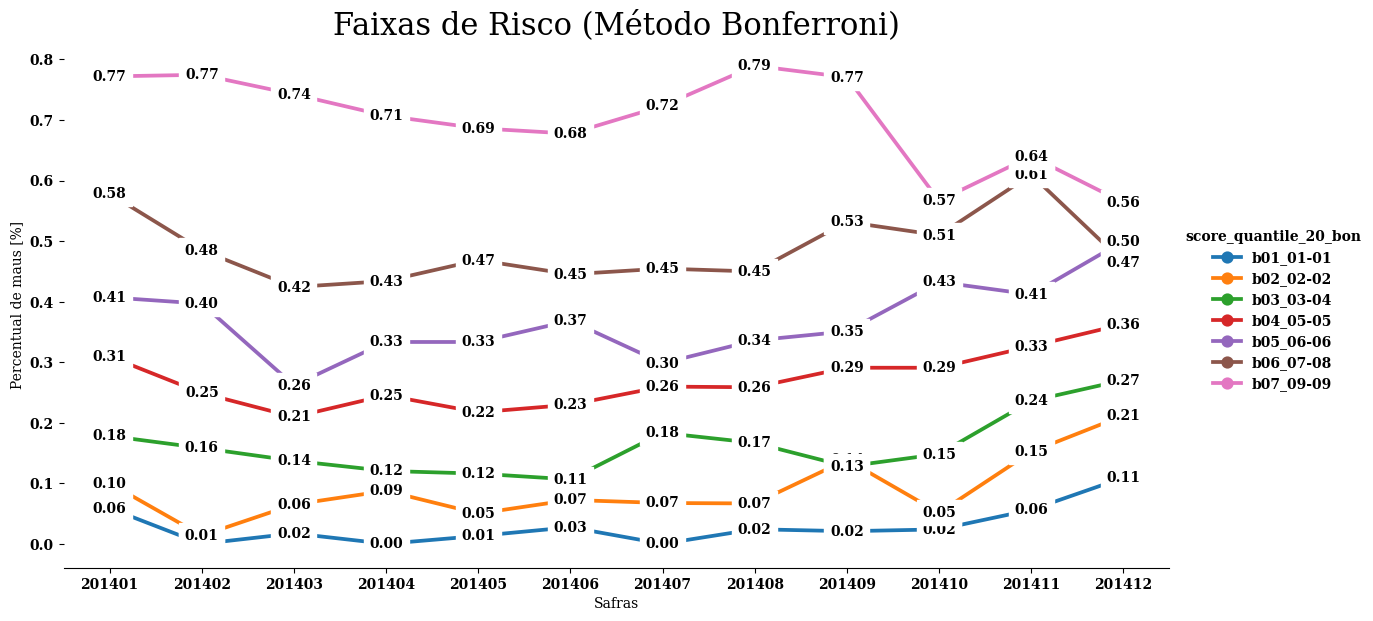

In [38]:
example= pd.DataFrame(df_full.groupby(['score_quantile_20_bon', 'safra'],as_index=False).apply(lambda x: x[target].sum()/len(x)))
example.columns = ['score_quantile_20_bon','year_month', 'Bad_Rate']


ax = sns.catplot(x="year_month", y="Bad_Rate", hue='score_quantile_20_bon', height=6, aspect=2,
                 capsize=.2, kind="point", data=example)

for ind_i, safra in enumerate(list(sorted(set(example['year_month'].values)))):
    for var in list(sorted(set(example['score_quantile_20_bon'].values))):
        value = example[(example['year_month']==safra)&(example['score_quantile_20_bon']==var)]['Bad_Rate'].values[0]
        ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)

ax.set(xlabel = 'Safras', ylabel = 'Percentual de maus [%]')
# plt.legend(title='Faixas de Risco', loc='upper right', bbox_to_anchor=(1.1, 0.7))
plt.title(f"Faixas de Risco (Método Bonferroni)", fontsize=22)
ax.despine(left=True)
plt.show()

In [39]:
def calculate_metrics(df, target, bins):
    ks = ks_2samp(df[df[target]==0][bins], df[df[target]==1][bins])
    
    return round(ks.statistic,2)

def calculate_ks_roc(df_full):
    list_dates = []

    list_ks = []
    list_auc = []

    list_ks_ori = []
    list_auc_ori = []

    for date in list(sorted(df_full['safra'].unique())):
        list_dates.append(date)
    
        df_tmp = df_full[df_full['safra']==date]
    
        #ks = calculate_metrics(df_tmp, 'over30', "bin")
        ks = calculate_metrics(df_tmp, target, "score_quantile_20_bon")
        list_ks.append(ks)
    
        fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp['predict_proba'])
        list_auc.append(np.round(auc(fpr, tpr), 2))
        
    
    df_ks = pd.DataFrame({'safra':list_dates, 'ks':list_ks, 'auc': list_auc})
    
    return df_ks

In [40]:
df_metrics = calculate_ks_roc(df_full)
df_metrics

,safra,ks,auc
0,201401,0.36,0.74
1,201402,0.37,0.75
2,201403,0.36,0.75
3,201404,0.34,0.74
4,201405,0.39,0.76
5,201406,0.39,0.76
6,201407,0.32,0.74
7,201408,0.35,0.74
8,201409,0.39,0.78
9,201410,0.37,0.76


In [41]:
ks_dev = np.round(df_metrics[df_metrics['safra']<=201408][['ks', 'auc']].median()['ks'],2)
ks_val = np.round(df_metrics[(df_metrics['safra'].isin([201409,201410]))][['ks', 'auc']].median()['ks'],2)
ks_out = np.round(df_metrics[(df_metrics['safra']>=201411)][['ks', 'auc']].median()['ks'],2)


In [42]:
font = {'family' : 'DeJavu Serif',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

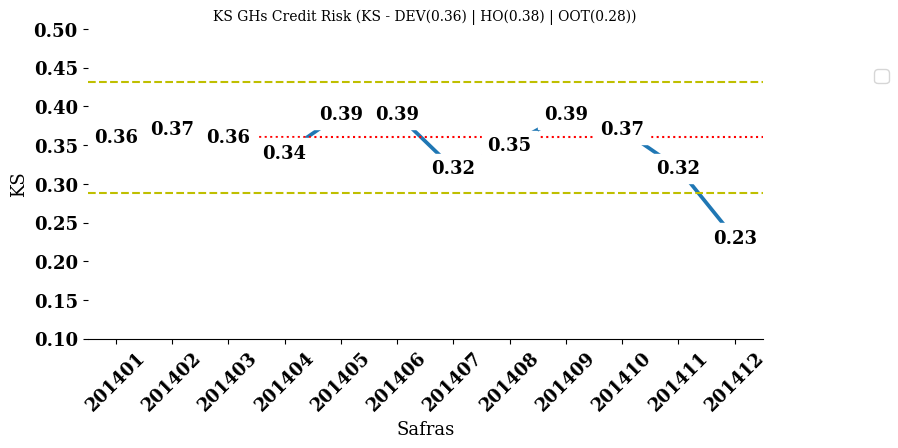

In [43]:
df_melted = pd.melt(df_metrics, id_vars=['safra'], var_name='variavel', value_name='valor')
df_melted_ks = df_melted[df_melted['variavel'].isin(['ks', 'ks_ori'])]

legend_mapping = {'ks': 'Ks Boost', 'ks_ori': 'Ks Atual'}
df_melted_ks['variavel'] = df_melted_ks['variavel'].map(legend_mapping)

ax = sns.catplot(x="safra", y="valor", hue='variavel', height=4, aspect=2, capsize=.2, kind="point", data=df_melted_ks, legend=False, palette = "tab10")

for ind_i, safra in enumerate(list(sorted(set(df_melted_ks['safra'].values)))):
    for var in list(sorted(set(df_melted_ks['variavel'].values))):
        value = df_melted_ks[(df_melted_ks['safra']==safra)&(df_melted_ks['variavel']==var)]['valor'].values[0]
        ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)
        
ax.set(xlabel = 'Safras', ylabel = 'KS')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))

plt.axhline(ks_dev*0.8,color='y', linestyle='dashed')
plt.axhline(ks_dev,color='r', linestyle='dotted')
plt.axhline(ks_dev*1.2,color='y', linestyle='dashed')

plt.title(f"KS GHs Credit Risk (KS - DEV({ks_dev}) | HO({ks_val}) | OOT({ks_out}))", fontsize=10)
ax.despine(left=True)
plt.xticks(rotation=45)
plt.ylim(0.1, 0.5)
plt.show()